In [29]:
import copy
import torch.nn.functional as F
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import time

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

from utils.file_utils import open_json, write_json, log_training
from utils.model import SimpleNN
from utils.model_utils import *



In [30]:
DIR_PATH = "./dataset"
config = open_json(f"{DIR_PATH}/config.json")
features_dict = open_json(f"{DIR_PATH}/features.json")
features = compute_feature_list(config, features_dict)

LOG_NAME = "SimpleNN"
COMPUTE_LEARNING_CURVE = True
COMPUTE_FEATURE_IMPORTANCE = True

In [31]:
if torch.cuda.is_available() and config["use_cuda"]:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

cpu


In [32]:
def train_model(model: SimpleNN, optimizer, loss_function, trainloader, device):
    loss_over_time = []
    # Run the training loop
    for epoch in range(config["num_epochs"]):
        # Set current loss value
        current_loss = 0.0
        # Iterate over the DataLoader for training data
        for i, data in enumerate(trainloader, 0):
            # Get and prepare inputs
            inputs, targets = data
            # inputs, targets = inputs.float(), targets.float()
            targets = targets.reshape((targets.shape[0], 1))
            # Move to cuda device
            inputs, targets = inputs.to(device), targets.to(device)
            # Zero the gradients
            optimizer.zero_grad()
            # Perform forward pass
            outputs = model(inputs)
            # Compute loss
            loss = loss_function(outputs, targets)
            # Perform backward pass
            loss.backward()
            # Perform optimization
            optimizer.step()

            current_loss += loss.item()
        loss_over_time.append(current_loss/(i+1))
    return model, loss_over_time


In [33]:
def k_fold_training(df, ksplit, config, features, device, keep_models=False):
    training_results = []
    model_list = [None]*config["k-fold"]
    scaler_list = [None]*config["k-fold"]

    for k in range(config["k-fold"]):
        train, test = next(ksplit)
        df_train = df[df["protein_index"].isin(train)]
        df_test = df[df["protein_index"].isin(test)]

        # we load the data for training
        dataset_train = prepare_train_data(df_train, config, features)
        trainloader = torch.utils.data.DataLoader(dataset_train,
                                                  batch_size=config["batch_size"],
                                                  shuffle=False,
                                                  num_workers=config["num_workers"])

        # we load the data for evaluation
        X_train, y_train = prepare_eval_data(
            df_train, config, features, dataset_train.scaler)
        X_test, y_test = prepare_eval_data(
            df_test, config, features, dataset_train.scaler)

        # Initialize a new Novozymes Model
        model = SimpleNN(len(features))
        model.to(torch.double)
        model.to(device)

        # Define the loss function and optimizer
        loss_function = nn.L1Loss()
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

        # Train model:
        t0 = time.time()
        model, loss_over_time = train_model(
            model, optimizer, loss_function, trainloader, device)
        t1 = time.time()-t0

        # Evaluate this model:
        model.eval()
        with torch.set_grad_enabled(False):
            train_mse = evaluate_model(X_train, y_train, model, device)
            test_mse = evaluate_model(X_test, y_test, model, device)
            # print(f"MSE obtained for k-fold {k}: {mse}")
            results = {"loss_over_time": loss_over_time,
                    "train_mse": train_mse,
                    "test_mse": test_mse,
                    "time": t1}
            training_results.append(results)
        
        # end of process for k, freeing memory
        # del model

        if keep_models:
            model_list[k] = copy.deepcopy(model)
            scaler_list[k] = copy.deepcopy(dataset_train.scaler)

    # Process is complete.

    return training_results, model_list, scaler_list


## Learning Curve

In [34]:
if COMPUTE_LEARNING_CURVE:
    df = pd.read_csv(f"{DIR_PATH}/{config['dataset_name']}.csv")

    # plot the learning curve of the model
    # ie. the avg mse when df has 10, 100, 1000 elements
    # len(df) = 5k
    num_rows = [100, 1000, 3000, len(df)]
    all_training_results = {"training_by_num_rows": [],
                            "learning_curve": {"num_rows": num_rows,
                                            "train_mse": [],
                                            "test_mse": []
                                            },
                            "total_training_time": 0
                            }

    t0 = time.time()
    for n in num_rows:
        print(f"training on {n} rows from the dataset")
        df_n_rows = df.sample(n)
        # add protein_index to the dataset and get ksplit:
        df_n_rows, ksplit = split_dataset(df_n_rows, config)
        training_results, _, _ = k_fold_training(
            df_n_rows, ksplit, config, features, device)

        # add training results to all the other ones
        all_training_results["training_by_num_rows"].append(training_results)
        # compute avg_mse and time
        train_mse = sum(x['train_mse']
                            for x in training_results)/config['k-fold']
        test_mse = sum(x['test_mse']
                        for x in training_results)/config['k-fold']
        training_time = sum(x['time'] for x in training_results)

        # update result variables
        all_training_results["total_training_time"] += training_time
        all_training_results["learning_curve"]["train_mse"].append(train_mse)
        all_training_results["learning_curve"]["test_mse"].append(test_mse)


    total_time = time.time()-t0
    print(f"total_training_time= {all_training_results['total_training_time']:.2f}, {total_time= :.2f}, \
        training_time: {(all_training_results['total_training_time']/total_time)*100:.2f}% of total time")


training on 100 rows from the dataset


KeyboardInterrupt: 

In [ ]:
if COMPUTE_LEARNING_CURVE:
    # save results to output
    model = SimpleNN(len(features))
    model_structure = str(model).replace('(', '').replace(')', '').split('\n')
    dir_path = log_training(LOG_NAME, all_training_results, config, features, model_structure)
    print(f"logged training in {dir_path}")

## Feature Importance

In [ ]:
if COMPUTE_FEATURE_IMPORTANCE:
    # all_training_results[feature1]: result obtained when df[feature1] = random
    all_training_results = {}
    
    df = pd.read_csv(f"{DIR_PATH}/{config['dataset_name']}.csv")

    # 1. we train k-fold models using all features:
    df, ksplit = split_dataset(df, config)
    ksplit_list = list(ksplit)
    training_results, model_list, scaler_list = k_fold_training(
        df, iter(ksplit_list), config, features, device, keep_models=True)

    # compute mse (with no feature randomized)
    none_random_train_mse = sum(x['train_mse']
                                for x in training_results)/config['k-fold']
    none_random_test_mse = sum(x['test_mse']
                                for x in training_results)/config['k-fold']
    all_training_results["none_randomized"] = {
        "train_mse": none_random_train_mse, "test_mse": none_random_test_mse}
    
    # 2. for each feature we take the df, randomize the feature column, then compute the new mse score with each model
    for feature in features:
        # create a copy of the dataset with the feature column being random
        df_random = copy.deepcopy(df)
        df_random[feature] = np.random.randint(-1000, 1000, df_random.shape[0])
        training_results = []

        # evaluate all model on this new dataset
        ksplit = iter(ksplit_list)
        for k in range(config["k-fold"]):
            # get the same ksplit as during training
            train, test = next(ksplit)
            model = model_list[k] # model result from the training
            dataset_train_scaler = scaler_list[k] # scaler from training

            # we load the data for evaluation
            df_train = df_random[df_random["protein_index"].isin(train)]
            df_test = df_random[df_random["protein_index"].isin(test)]
            X_train, y_train = prepare_eval_data(
                df_train, config, features, dataset_train_scaler)
            X_test, y_test = prepare_eval_data(
                df_test, config, features, dataset_train_scaler)

            # Evaluate this model:
            model.eval()
            with torch.set_grad_enabled(False):
                train_mse = evaluate_model(X_train, y_train, model, device)
                test_mse = evaluate_model(X_test, y_test, model, device)
                # print(f"MSE obtained for k-fold {k}: {mse}")
                results = {
                        "train_mse": train_mse,
                        "test_mse": test_mse
                        }
                training_results.append(results)
                
        # compute avg_mse
        train_mse = sum(x['train_mse']
                        for x in training_results)/config['k-fold']
        test_mse = sum(x['test_mse']
                    for x in training_results)/config['k-fold']
        # add training results to all the other ones
        all_training_results[feature] = {
            "train_mse": train_mse, "test_mse": test_mse, 
            "delta_train_mse": train_mse-none_random_train_mse,
            "delta_test_mse": test_mse-none_random_test_mse,
            }

    # rank results
    ranked_delta_test_mse = [[x, all_training_results[x].get(
        "delta_test_mse", 0)] for x in all_training_results.keys()]
    ranked_delta_test_mse.sort(key=lambda x: x[1], reverse=True)
    write_json(f"./outputs/{LOG_NAME}_feature_importance.json",
               {"ranked_delta_test_mse": ranked_delta_test_mse,
                "all_training_results": all_training_results})


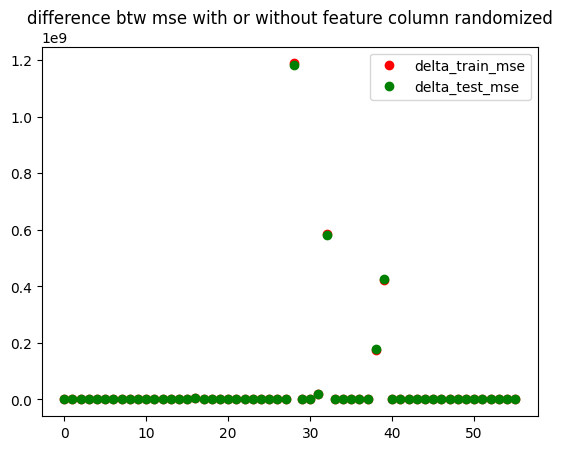

In [ ]:
if COMPUTE_FEATURE_IMPORTANCE:
    # plot the difference with the mse with no random columns for each feature
    delta_train_mse = [all_training_results[x].get(
        "delta_train_mse", 0) for x in all_training_results.keys()]
    delta_test_mse = [all_training_results[x].get(
        "delta_test_mse", 0) for x in all_training_results.keys()]

    plt.plot(delta_train_mse, "or", label="delta_train_mse")
    plt.plot(delta_test_mse, "og", label="delta_test_mse")
    plt.legend()
    plt.title(
        "difference btw mse with or without feature column randomized")
    plt.savefig(f"{LOG_NAME}_feature_importance.jpg")


# Predicting on submission

In [ ]:
# results = model(X_test)
# results[:10]

In [ ]:
# submission = pd.DataFrame(columns=["seq_id", "tm"])
# submission["seq_id"] = df["seq_id"]
# submission["tm"] = results.detach().numpy() * -1
# submission.head()

In [ ]:
# save_submission(submission)